# Model hierarchy

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from convergence.plotting import plot_faverage_parcelation, add_area_labels
from convergence.operations import interpolate_alignment_series, unpack_scores
import matplotlib.ticker as ticker

## Load and interpolate data

In [2]:

#df = pd.read_parquet("data/subject_model_similarities_cka.parquet")
df = pd.read_parquet("data/subject_model_similarities_cka_joined.parquet")
df = df.query("not excluded and metric=='unbiased_cka'").rename(columns={"model_name": "model"})
hcp = pd.read_csv("data/hcp2.csv")
hcp = hcp[["roi", "name", "area", "mne_name", "area_id", "area_color", "roi_order"]]

groups = ["subject", "modality", "model",  "roi", "layer"]
df_m = df[(df.score < 1) & (df.score > -0.2)]
df_m = df_m.groupby(groups, observed=True).aggregate({'score': "median"}).reset_index()

groups = ["subject", "modality", "model", "roi"]

df_interpolated = interpolate_alignment_series(
    df=df_m,
    groups=groups,
    layer_column="layer",
    score_column="score",
    interp_scores_column="scores",
)


def group_func(x):
    return np.mean(np.stack(x.values), axis=0)
groups = ["subject", "roi", "modality"]
df_interpolated_modality = df_interpolated.groupby(groups, observed=False).aggregate({"scores": group_func}).reset_index()
df_interpolated_modality = unpack_scores(df_interpolated_modality)
df_interpolated_modality = df_interpolated_modality.merge(hcp, on="roi")

## Curves of selected rois

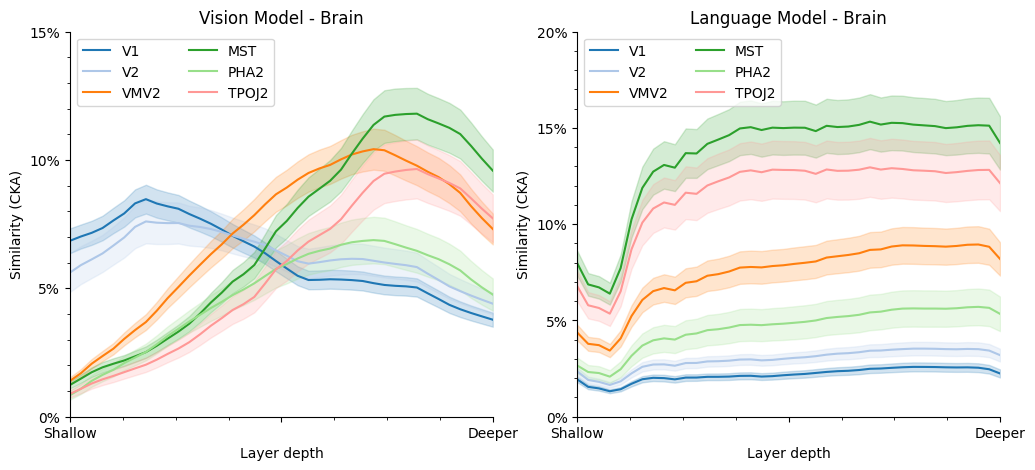

In [6]:
# names = ["MST", "MT", "FST", "V4t", "V1", "V2", "V3", "V4", "VMV1", "VMV2", "PHA1", "PHA2", "PHA3", "TPOJ2", "TPOJ3"]
names = ["V1", "V2", "MST", "VMV2", "PHA2", "TPOJ2"]  # , "PHT", "V3A"]


def plot_curves(data, ax, ymax=0.15, ylabel=""):
    data["layer"] = data.layer.astype("float") * (40 / 39)
    g = sns.lineplot(
        data=data,
        x="layer",
        y="score",
        hue="name",
        ax=ax,
        errorbar="se",
        palette=palette,
        hue_order=hue_order,
    )
    ax.set_ylim(0, ymax)
    ax.set_xlim(0, 40)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))

    xlabels = {1:"Shallow", 3: "Deeper"}
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, i: xlabels.get(int(i), "")))
    ax.set_xlabel("")
    ax.legend(loc="upper left", ncols=2)
    sns.despine(ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Layer depth")
    # ax.grid(axis="y", which="major", linestyle="--", zorder=-10)
    return fig, ax


# Vision model
data = df_interpolated_modality.query("modality=='vision' and name in @names").copy()
data.name = data.name.astype("string")
data = data.sort_values(["area_id", "roi_order"])
hue_order = list(data.name.unique())
palette = data.sort_values(["area_id", "roi_order"]).drop_duplicates("name").area_color.tolist()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

fig, ax = plot_curves(data, ax=ax1, ylabel="Similarity (CKA)")
ax.set_title("Vision Model - Brain")

# Language model
data = df_interpolated_modality.query(
    "modality=='language' and name in @names"
).copy()
data.name = data.name.astype("string")
data = data.sort_values(["area_id", "roi_order"])
hue_order = list(data.name.unique())
palette = data.sort_values(["area_id", "roi_order"]).drop_duplicates("name").area_color.tolist()

fig, ax = plot_curves(data, ax=ax2, ymax=0.2, ylabel="Similarity (CKA)")
ax.set_title("Language Model - Brain")
fig.savefig("layerwise_similarity_cka.svg", bbox_inches="tight", transparent=True)

## Max layer

In [2]:
df = pd.read_parquet("data/subject_model_similarities_cka.parquet")
df = df.query("not excluded and metric=='unbiased_cka'").rename(columns={"model_name": "model"})
hcp = pd.read_csv("data/hcp2.csv")
# Get max layer by model name and add it as a column
df["max_layer"] = df.groupby(["subject", "modality", "model", "roi"], observed=True)[
    "layer"
].transform("max")
df["layer"] = df["layer"].astype("float") / df["max_layer"]
df = df[(df.score < 1) & (df.score > -0.2)]
df = df.sort_values(["subject", "modality", "model", "roi", "session", "score"])
df_max_layer = df.drop_duplicates(
    ["subject", "modality", "model", "roi", "session"], keep="last"
)
df_max_layer = df_max_layer.groupby(["subject", "modality", "model", "roi"], observed=True).aggregate({"layer": "mean", "score": "mean"}).reset_index()
df_max_layer = df_max_layer.groupby(["subject", "modality","roi"], observed=True).aggregate({"layer": "mean", "score": "mean"}).reset_index()
df_max_layer = df_max_layer.groupby(["modality","roi"], observed=True).aggregate({"layer": "mean", "score": "mean"}).reset_index()
df_max_layer = df_max_layer.merge(hcp, on="roi")

In [ ]:
brain = plot_faverage_parcelation(
    df_max_layer.query("modality=='vision' and score > 0.03"),
    value_column="layer",
    cmap="coolwarm",
    normalize=(0.2, 0.8),
    default_color="black",
    default_value=None,
    hemisphere="rh",
    size=(1024, 1024),
    smooth=0,
)
brain.show_view("lateral", azimuth=-20, elevation=100)
brain.save_image("layer_depth_lateral_rh.png", mode="rgba")
brain.show_view("medial", elevation=-100, azimuth=20)
brain.save_image("layer_depth_medial_rh.png", mode="rgba")

areas = list(df_max_layer.query("modality=='vision' and score > 0.03").area_id.unique())
add_area_labels(brain=brain, hcp=hcp, area_ids=areas, hemispheres=["rh"])
brain.show_view("lateral", azimuth=-20, elevation=100)
brain.save_image("layer_depth_lateral_rh_annotated.png", mode="rgba")
brain.show_view("medial", elevation=-100, azimuth=20)
brain.save_image("layer_depth_medial_rh_annotated.png", mode="rgba")

brain.close()

In [28]:
brain = plot_faverage_parcelation(
    df_max_layer.query("modality=='vision' and score > 0.03"),
    value_column="layer",
    cmap="coolwarm",
    normalize=(0.2, 0.8),
    default_color="black",
    default_value=None,
    size=(1024, 1024),
    smooth=0,
)
brain.show_view("ventral", azimuth=10, elevation=-180)
brain.save_image("layer_depth_ventral.png", mode="rgba")
add_area_labels(brain=brain, hcp=hcp, area_ids=areas)
brain.show_view("ventral", azimuth=10, elevation=-180)
brain.save_image("layer_depth_ventral_annotated.png", mode="rgba")
brain.close()

## Video

In [ ]:
from tqdm import trange
from pathlib import Path

dd = df_interpolated_modality.query("modality == 'vision'").groupby(["modality", "roi", "layer"], observed=True).aggregate({"score": "mean"}).reset_index()
dd = dd.merge(hcp, on="roi")

Path("video").mkdir(exist_ok=True)

vmin, vmax = (0, 0.12)
for layer in trange(0, 40):
    brain = plot_faverage_parcelation(dd.query("layer == @layer"), normalize=(vmin, vmax))
    brain.show_view("lateral")
    brain.save_image(f"video/brain_cka_lateral_layer_{layer}.png")
    brain.show_view("caudal")
    brain.save_image(f"video/brain_cka_caudal_layer_{layer}.png")
    brain.show_view("medial")
    brain.save_image(f"video/brain_cka_medial_layer_{layer}.png")
    brain.show_view("ventral")
    brain.save_image(f"video/brain_cka_ventral_layer_{layer}.png")
    brain.close()

In [ ]:
#from dmf.video import VideoWriter


for layer in trange(0, 40):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes = axes.ravel()

    img = plt.imread(f"video/brain_cka_lateral_layer_{layer}.png")
    axes[0].imshow(img)
    axes[0].axis("off")
    x = 99
    axes[0].set_xlim(0+x, 800-x)
    y = 80
    axes[0].set_ylim(600-y, y)

    img = plt.imread(f"video/brain_cka_caudal_layer_{layer}.png")
    axes[3].imshow(img)
    axes[3].axis("off")
    x = 90
    axes[3].set_xlim(0+x, 800-x)
    axes[3].set_ylim(None, 80)

    img = plt.imread(f"video/brain_cka_medial_layer_{layer}.png")
    axes[1].imshow(img)
    axes[1].axis("off")
    x = 99
    axes[1].set_xlim(x, 800-x)

    img = plt.imread(f"video/brain_cka_ventral_layer_{layer}.png")
    axes[2].imshow(img)
    axes[2].axis("off")
    x = 150
    axes[2].set_xlim(0+x, 800-x)

    # Add a cbar to the last axis. hot cmap from 0 to 12
    cbar = axes[3].inset_axes([0.05, 0.05, 0.9, 0.05])
    norm = plt.Normalize(vmin, vmax)
    sm = plt.cm.ScalarMappable(cmap="hot", norm=norm)
    sm.set_array([])

    plt.colorbar(sm, cax=cbar, orientation="horizontal")
    cbar.set_xlabel("Similarity (CKA)")
    # percent formatter
    from matplotlib.ticker import PercentFormatter
    cbar.xaxis.set_major_formatter(PercentFormatter(1, 0))

    # Adjust spacing
    plt.subplots_adjust(wspace=0.01, hspace=-0.1)

    fig.suptitle(f"Vision Models Alignment - Layer {layer/39:.0%}", position=(0.5, 0.85))
    fig.savefig(f"video/frame_{layer:02d}.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
    # Close all figures
    plt.close("all")